In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
def import_basel_data():
    data = pd.read_csv("../raw_data/Basel_Daten.csv", delimiter=';')
    return data

def get_location_data(df, location):
    mask = df['SiteName'] == location
    return df[mask], df[~mask]

def clean_location_data(location_df):
    stamps = [x.split('+')[0] for x in location_df['DateTimeFrom'].values]
    location_df = location_df.assign(Time=pd.to_datetime(stamps.copy(), format="%Y-%m-%dT%H:%M:%S"))
    location_df = location_df.set_index('Time')
    location_df = location_df.assign(Day=location_df.index.day)
    return location_df

def get_location_split_dict(data):
    location_dict = {}
    #Alle Orte
    locs = sorted(list(set(data['SiteName'])))
    for loc in locs:
        location_df, data = get_location_data(data, loc)
        location_dict[loc] = clean_location_data(location_df)
    return location_dict

def resample_location_data(location_df, frequency):
    if frequency == 'D':
        cols = ['Total']
    elif frequency == 'H':
        cols = ['Total', 'Month', 'Day', 'Weekday', 'HourFrom']
    else:
        print("INCORRECT FREQUENCY")
    location_df = location_df[cols].resample(frequency).sum()
    return location_df

In [3]:
%matplotlib inline

def location_plot(location_hourly_sum, adresse, show=0, ax2=None):

    plotdata = location_hourly_sum[adresse]
    data_by_day = {"%d:%d"%(mk,dk):dv.sort_values(by=['HourFrom']) for mk, mv in plotdata.groupby('Month')
                                                                         for dk, dv in mv.groupby('Day')}

    if show == 2:
        fig, ax = plt.subplots(4,2, figsize=(10,13))
        #Flatten
        ax = [x for y in ax for x in y]
    mean = np.zeros((7,24))
    numb = np.array(7*[0])
    
    for i in range(1, len(data_by_day)):
        vals = list(data_by_day.values())[i]
        thisday = vals['Weekday'].values[0]
        if len(vals['Weekday'].values) == 24:
            numb[thisday] += 1
            mean[thisday,:] += np.array(list(data_by_day.values())[i]['Total'].values)
            if show == 2:
                ax[thisday].plot(list(data_by_day.values())[i]['Total'].values, alpha=0.3, c='blue')

    mean = mean/np.reshape(numb,(7,1))
    if show >= 1:
        showLater = True
        if ax2==None:
            showLater = False
            fig, ax2 = plt.subplots(figsize=(10,8))
        cs=5*['blue']+['orange']+['red']
        for i in range(7):
            ax2.plot(mean[i], c=cs[i])
        if not showLater:
            ax2.legend(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
            plt.show()
    
    return mean

In [4]:
def elbow(Z):
    distortions = []
    for i in range(1, 11):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(Z)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

In [5]:
def cluster_locations(location_hourly_sum, Z, locs, i, j, plot=True):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(Z)
    results = km.predict(Z)
    wow = [list(np.array(locs)[results == j]) for j in range(i)]
    
    if plot:
        fig,ax = plt.subplots(i,j, figsize=(7*i,4*j))
        for a in range(i):
            for b in range(j):
                if b < len(wow[a]):
                    location_plot(location_hourly_sum, wow[a][b], show=1, ax2=ax[a,b])
                    
    return {locs[i]:results[i] for i in range(len(locs))}

In [6]:
def get_cluster_roles(location_hourly_sum, locs):
    locs = sorted(list(set(data['SiteName'])))
    X = [location_plot(location_hourly_sum, loc) for loc in locs]
    
    #Factor 1/11 - 3/11
    Z = (np.array(X) * np.array(43 * [[24*[1],24*[1],24*[1],24*[1],24*[1],24*[3],24*[3]]])).reshape((43,168))
    #Z = np.array(X).reshape((43,168))
    #Z * np.array(43*[0])
    mz = np.mean(Z, axis=1)
    Z = Z/np.reshape(mz,(43,1))
    
    return cluster_locations(location_hourly_sum,Z,locs,4,5, plot=False)

In [7]:
def plot_cluster_representations(location_hourly_sum, locs):
    X = [location_plot(location_hourly_sum, loc) for loc in locs]
    
    #Factor 1/11 - 3/11
    Z = (np.array(X) * np.array(43 * [[24*[1],24*[1],24*[1],24*[1],24*[1],24*[3],24*[3]]])).reshape((43,168))
    #Z = np.array(X).reshape((43,168))
    #Z * np.array(43*[0])
    mz = np.mean(Z, axis=1)
    Z = Z/np.reshape(mz,(43,1))
    
    elbow(Z)
    cluster_locations(location_hourly_sum,Z,locs,4,5, plot=True)

In [8]:
data = import_basel_data()
location_hourly_sum = {}
location_daily_sum = {}
locs = sorted(list(set(data['SiteName'])))
print(locs)
for loc, loc_data in get_location_split_dict(data).items():
    location_daily_sum[loc] = resample_location_data(loc_data, 'D')    
    location_hourly_sum[loc] = resample_location_data(loc_data, 'H')

['350 Dreirosenbrücke', '352 Johanniterbrücke', '354 Wettsteinbrücke', '403 Heuwaage-Viadukt', '405 Dorenbachviadukt', '659 Schlachthofstrasse', '660 Flughafenstrasse', '802 Klybeckstrasse 113/Kirche', '803 Johanniterbrücke', '804 Rosentalstrasse 29/28', '805 Rebgasse 11/28', '806 Gerbergasse', '807 Güterstrasse 180/183', '808 Wolfschlucht-Promenade', '809 Allschwilerstrasse 77/86', '810 Neubadstrasse 124/137', '811 Mülhauserstrasse 110/122', '812 Wettsteinbrücke', '813 Hardstrasse 66/77', '814 Elisabethenstrasse 46*', '815 Mittlere Rheinbrücke', '816 Schmiedgasse 4/7 (Riehen)', '817 Elisabethenanlage', '901 Peter-Merian Weg', '902 Viaduktstrasse', '903 Äussere Baselstrasse 328', '904 Hammerstrasse 90', '905 Leimenstrasse 4', '906 Hegenheimerstrasse 44', '907 Wasgenring 62', '908 Grenzacherstrasse (Kraftwerk)', '909 General Guisan-Strasse 104', '910 St. Galler-Ring 101', '911 Birskopfsteg', '912 Elsässerstrasse 261/260', '913 Burgfelderstrasse', '914 Hiltalingerstrasse', '915 Luzernerr

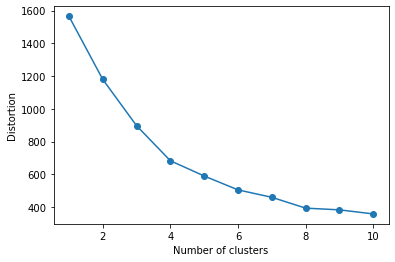

{'350 Dreirosenbrücke': 3, '352 Johanniterbrücke': 3, '354 Wettsteinbrücke': 3, '403 Heuwaage-Viadukt': 3, '405 Dorenbachviadukt': 2, '659 Schlachthofstrasse': 3, '660 Flughafenstrasse': 3, '802 Klybeckstrasse 113/Kirche': 1, '803 Johanniterbrücke': 1, '804 Rosentalstrasse 29/28': 2, '805 Rebgasse 11/28': 1, '806 Gerbergasse': 1, '807 Güterstrasse 180/183': 1, '808 Wolfschlucht-Promenade': 1, '809 Allschwilerstrasse 77/86': 1, '810 Neubadstrasse 124/137': 1, '811 Mülhauserstrasse 110/122': 1, '812 Wettsteinbrücke': 1, '813 Hardstrasse 66/77': 1, '814 Elisabethenstrasse 46*': 1, '815 Mittlere Rheinbrücke': 1, '816 Schmiedgasse 4/7 (Riehen)': 1, '817 Elisabethenanlage': 1, '901 Peter-Merian Weg': 3, '902 Viaduktstrasse': 3, '903 Äussere Baselstrasse 328': 2, '904 Hammerstrasse 90': 2, '905 Leimenstrasse 4': 2, '906 Hegenheimerstrasse 44': 2, '907 Wasgenring 62': 2, '908 Grenzacherstrasse (Kraftwerk)': 2, '909 General Guisan-Strasse 104': 2, '910 St. Galler-Ring 101': 2, '911 Birskopfsteg

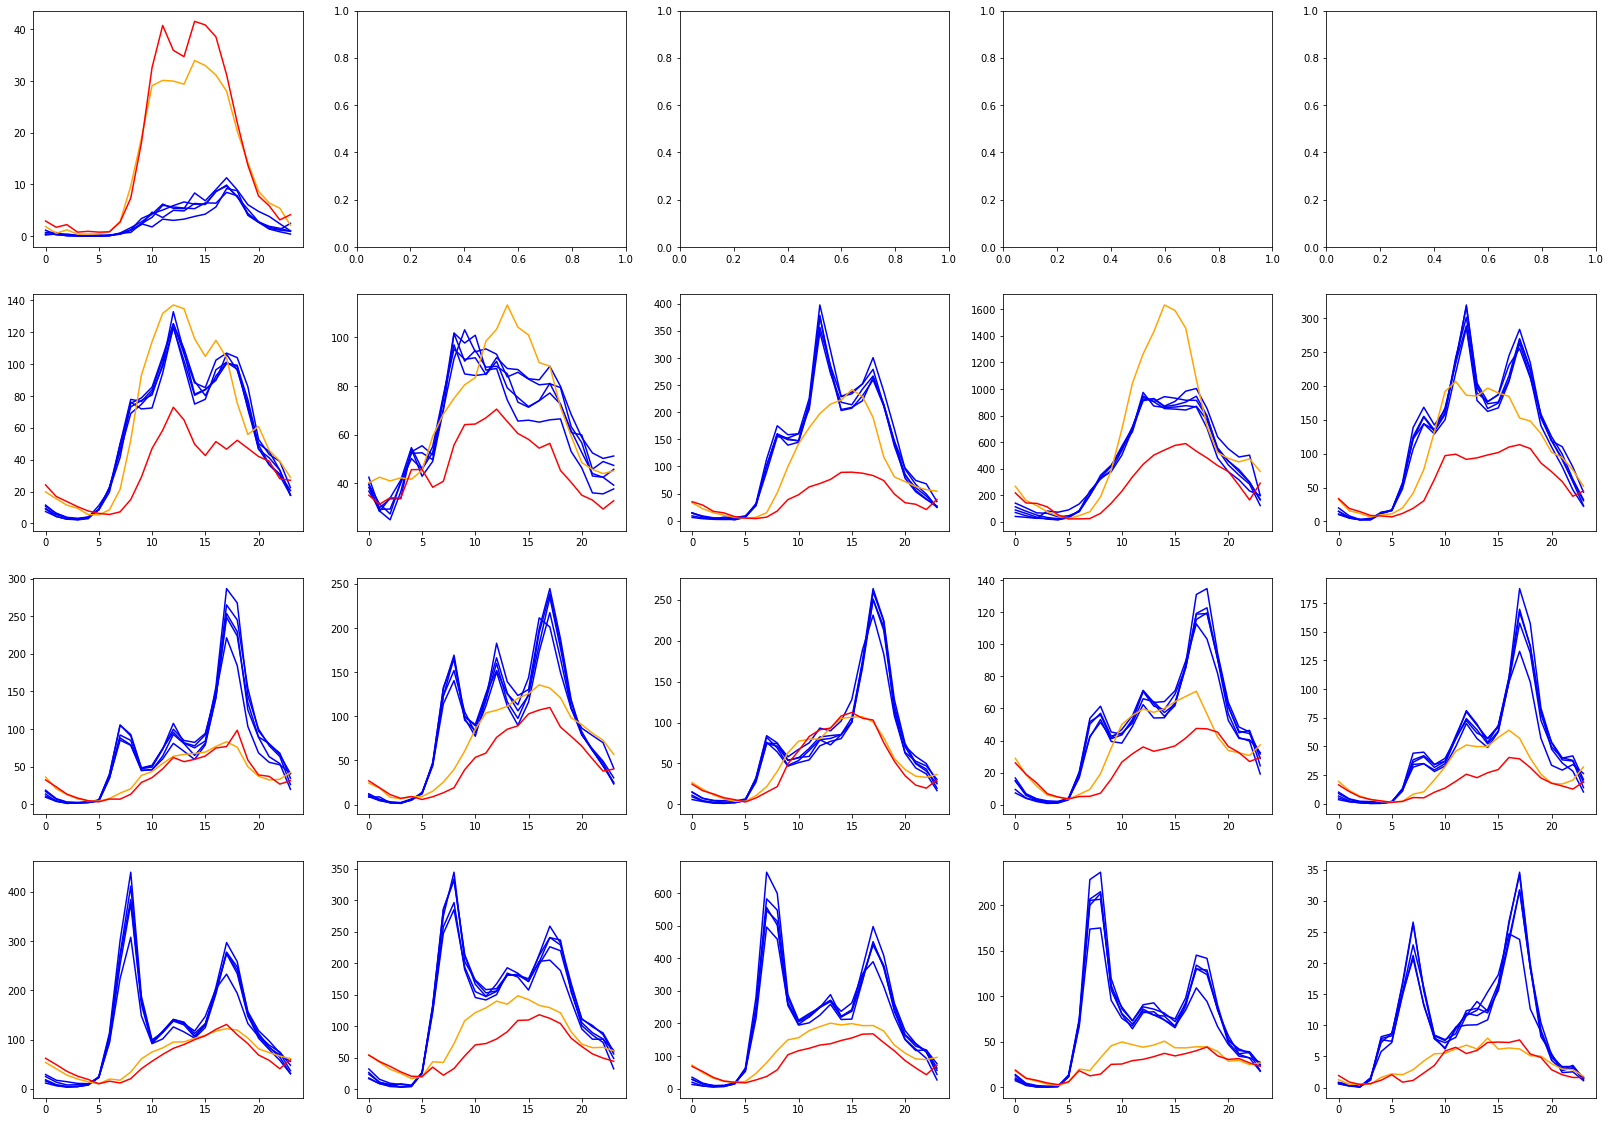

In [9]:
plot_cluster_representations(location_hourly_sum, locs)
print(get_cluster_roles(location_hourly_sum, locs))

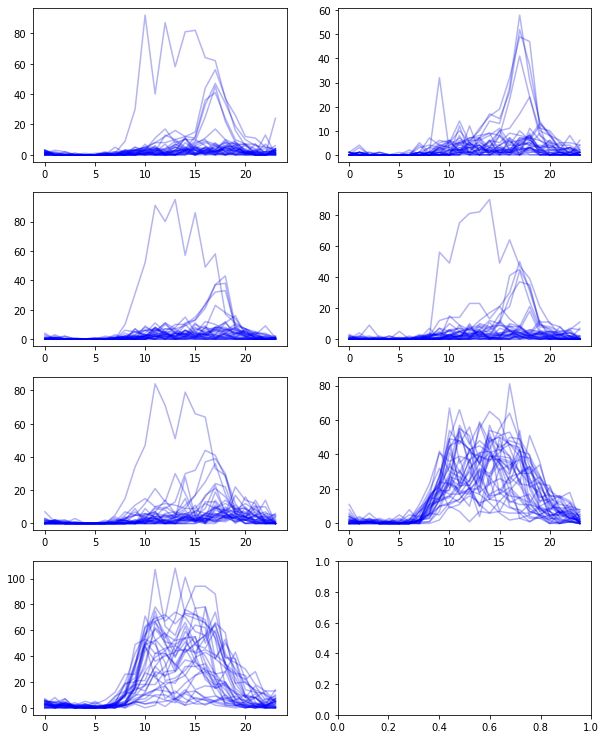

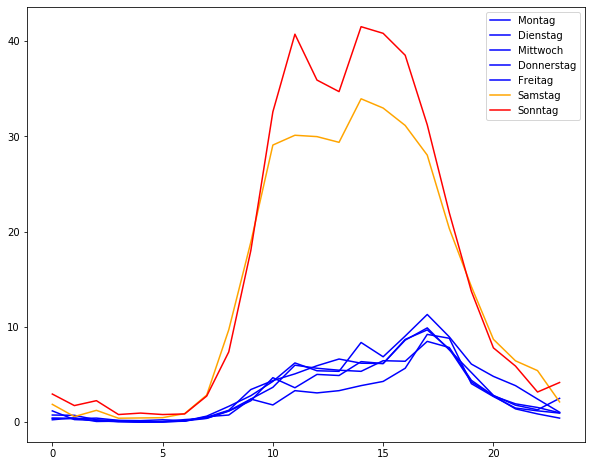

array([[1.17142857e+00, 2.57142857e-01, 1.71428571e-01, 5.71428571e-02,
        2.85714286e-02, 2.85714286e-02, 2.57142857e-01, 4.00000000e-01,
        1.14285714e+00, 2.22857143e+00, 4.65714286e+00, 3.60000000e+00,
        5.00000000e+00, 4.88571429e+00, 6.34285714e+00, 6.14285714e+00,
        8.60000000e+00, 9.88571429e+00, 7.57142857e+00, 5.20000000e+00,
        2.80000000e+00, 1.77142857e+00, 1.28571429e+00, 2.48571429e+00],
       [2.35294118e-01, 4.41176471e-01, 5.88235294e-02, 8.82352941e-02,
        0.00000000e+00, 2.94117647e-02, 8.82352941e-02, 5.58823529e-01,
        7.35294118e-01, 2.41176471e+00, 1.79411765e+00, 3.29411765e+00,
        3.05882353e+00, 3.29411765e+00, 3.82352941e+00, 4.26470588e+00,
        5.64705882e+00, 9.20588235e+00, 8.79411765e+00, 4.02941176e+00,
        2.67647059e+00, 1.47058824e+00, 1.17647059e+00, 9.41176471e-01],
       [3.82352941e-01, 3.82352941e-01, 1.47058824e-01, 2.94117647e-02,
        0.00000000e+00, 5.88235294e-02, 1.17647059e-01, 3.8235

In [10]:
location_plot(location_hourly_sum, '918 Elsässerrheinweg', show=2)

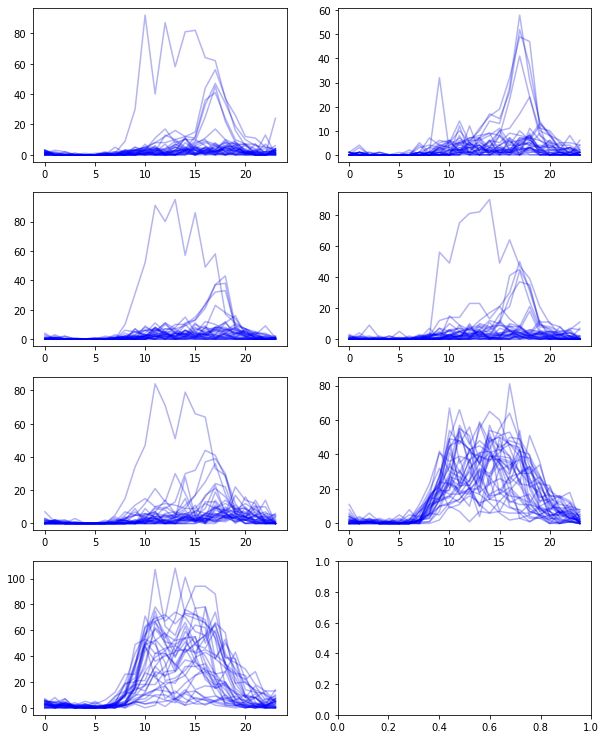

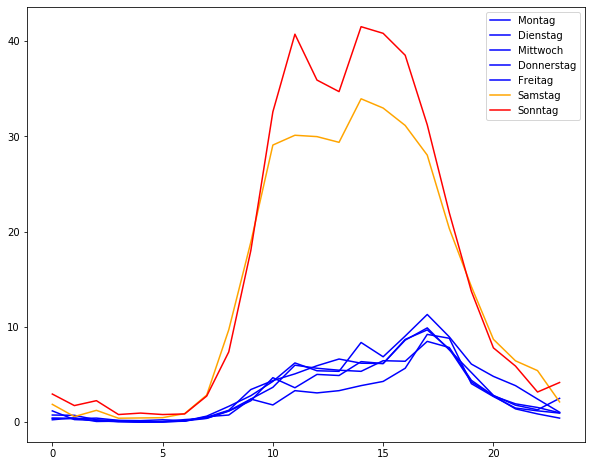

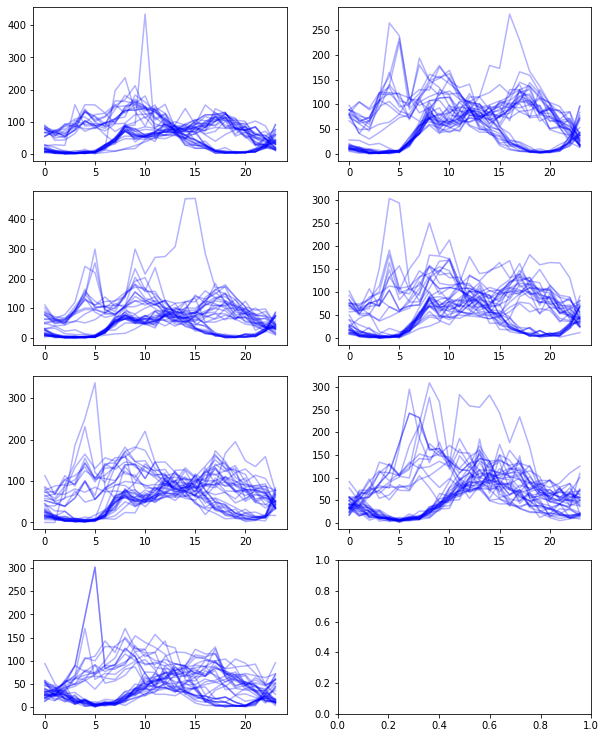

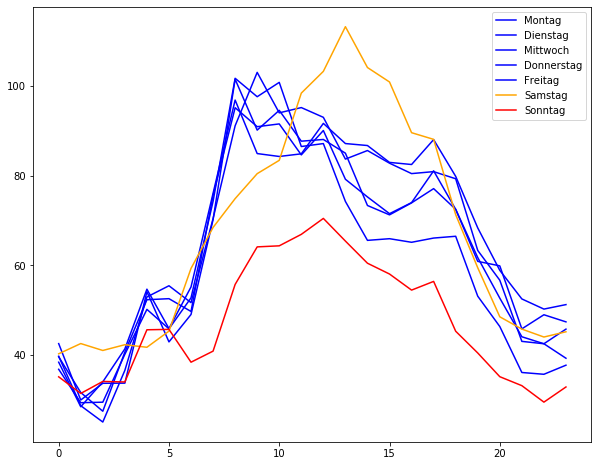

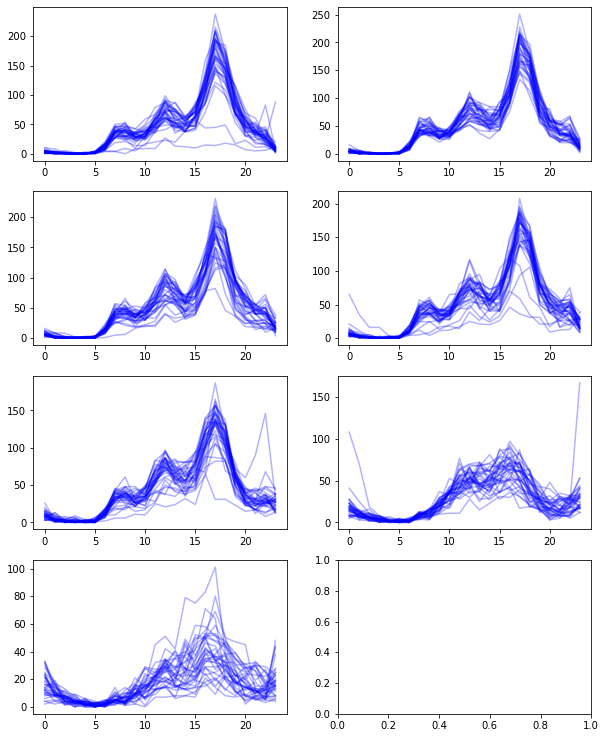

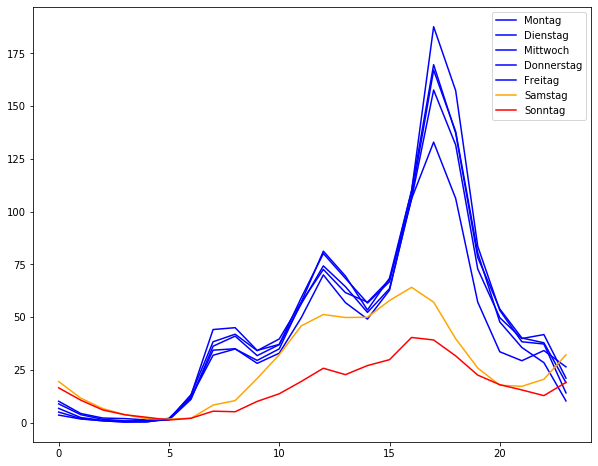

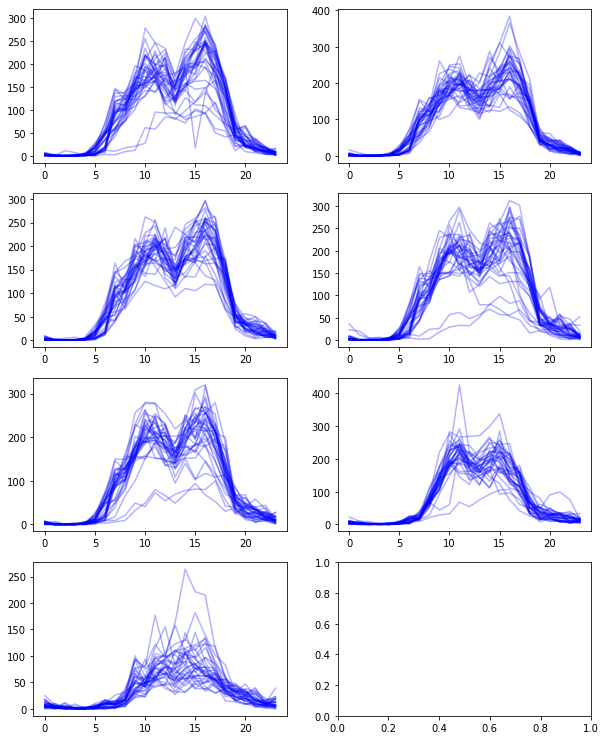

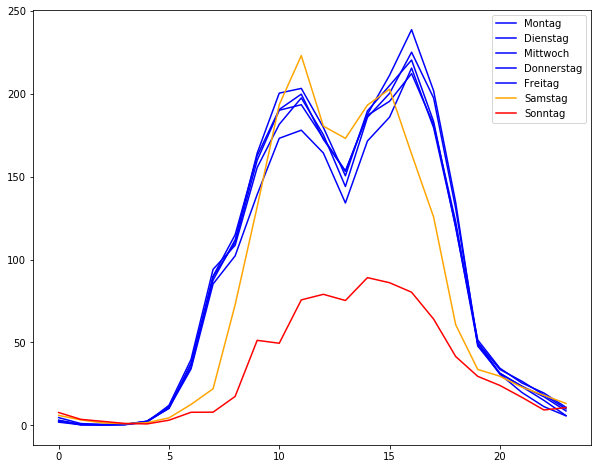

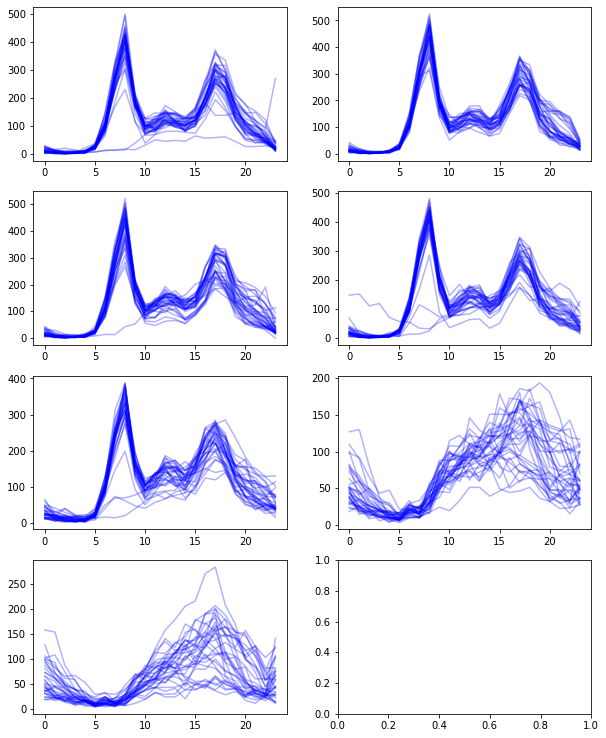

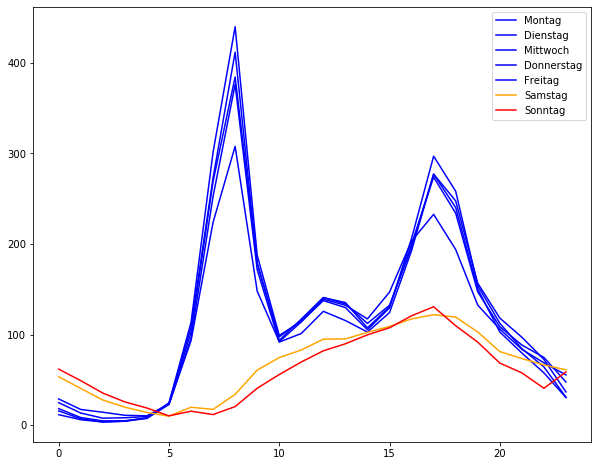

In [11]:
location_group = {'350 Dreirosenbrücke': 3, '352 Johanniterbrücke': 3, '354 Wettsteinbrücke': 3,
                      '403 Heuwaage-Viadukt': 3, '405 Dorenbachviadukt': 2, '659 Schlachthofstrasse': 3,
                      '660 Flughafenstrasse': 3, '802 Klybeckstrasse 113/Kirche': 1, '803 Johanniterbrücke': 1,
                      '804 Rosentalstrasse 29/28': 2, '805 Rebgasse 11/28': 1, '806 Gerbergasse': 1,
                      '807 Güterstrasse 180/183': 1, '808 Wolfschlucht-Promenade': 1, '809 Allschwilerstrasse 77/86': 1,
                      '810 Neubadstrasse 124/137': 1, '811 Mülhauserstrasse 110/122': 1, '812 Wettsteinbrücke': 1,
                      '813 Hardstrasse 66/77': 1, '814 Elisabethenstrasse 46*': 1, '815 Mittlere Rheinbrücke': 1,
                      '816 Schmiedgasse 4/7 (Riehen)': 1, '817 Elisabethenanlage': 1, '901 Peter-Merian Weg': 3,
                      '902 Viaduktstrasse': 3, '903 Äussere Baselstrasse 328': 2, '904 Hammerstrasse 90': 2,
                      '905 Leimenstrasse 4': 2, '906 Hegenheimerstrasse 44': 2, '907 Wasgenring 62': 2,
                      '908 Grenzacherstrasse (Kraftwerk)': 2, '909 General Guisan-Strasse 104': 2,
                      '910 St. Galler-Ring 101': 2, '911 Birskopfsteg': 2, '912 Elsässerstrasse 261/260': 2,
                      '913 Burgfelderstrasse': 3, '914 Hiltalingerstrasse': 1, '915 Luzernerring-Brücke': 3,
                      '916 Stückisteg': 1, '917 Schwarzwaldbrücke': 3, '918 Elsässerrheinweg': 0,
                      '919 St. Alban-Rheinweg': 2, '920 J. Burckhardt-Strasse': 3}

showcase = ['918 Elsässerrheinweg', '803 Johanniterbrücke','905 Leimenstrasse 4','816 Schmiedgasse 4/7 (Riehen)', '350 Dreirosenbrücke']
'''for loc, n in location_group.items():
    if n == 3:
        location_plot(location_hourly_sum, loc, show=2)
'''
for loc in showcase:
    location_plot(location_hourly_sum, loc, show=2)

In [12]:
def get_mean(location_hourly_sum, locs):
    X = [location_plot(location_hourly_sum, loc) for loc in locs]
    
    #Factor 1/11 - 3/11
    Z = (np.array(X) * np.array(43 * [[24*[1],24*[1],24*[1],24*[1],24*[1],24*[3],24*[3]]]))
    Z2 = Z.reshape((43,168))
    #Z = np.array(X).reshape((43,168))
    #Z * np.array(43*[0])
    mz = np.mean(Z2, axis=1)
    return Z

In [13]:
mz = get_mean(location_hourly_sum, locs)
mz.shape
location_hourly_sum

{'350 Dreirosenbrücke':                      Total  Month  Day  Weekday  HourFrom
 Time                                                     
 2019-03-30 20:00:00     68      3   30        5        20
 2019-03-30 21:00:00     59      3   30        5        21
 2019-03-30 22:00:00     63      3   30        5        22
 2019-03-30 23:00:00     62      3   30        5        23
 2019-03-31 00:00:00     53      3   31        6         0
 ...                    ...    ...  ...      ...       ...
 2019-11-27 19:00:00    131     11   27        2        19
 2019-11-27 20:00:00     89     11   27        2        20
 2019-11-27 21:00:00     65     11   27        2        21
 2019-11-27 22:00:00     49     11   27        2        22
 2019-11-27 23:00:00     19     11   27        2        23
 
 [5812 rows x 5 columns],
 '352 Johanniterbrücke':                      Total  Month  Day  Weekday  HourFrom
 Time                                                     
 2017-08-05 21:00:00    106      8    5 